In [3]:
import gym
from tqdm.notebook import tqdm
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from importlib import reload
import wandb
import torch

from Learning.utils import ReplayBuffer, plot
import Learning.agents as ag
import Envs.AYS.AYS_Environment as ays

In [9]:
UPDATE_ONLINE = False
BATCH_SIZE = 128
MAX_EPISODES = 5000
RANDOM_EXPERIENCE = 0
LEARNING_RATE = 3e-4
BUFFER_SIZE = 10000
REWARD_TYPE = 'PB'
DT = 1
SCHEDULER = (False, 1000, 0.5)

wandbsave = True

config = {
    "learning_rate": LEARNING_RATE,
    "max_episodes": MAX_EPISODES,
    "batch_size": BATCH_SIZE, 
    "online_updating": UPDATE_ONLINE,
    "random_experience": RANDOM_EXPERIENCE,
    "buffer_size": BUFFER_SIZE,
    "reward_type": REWARD_TYPE,
    "dt": DT,
    "scheduler": SCHEDULER
}

env = ays.AYS_Environment(dt=DT, reward_type=REWARD_TYPE)
state_dim = len(env.observation_space)
action_dim = len(env.action_space)

reload(ag)
memory = ReplayBuffer(BUFFER_SIZE)
agent = ag.ActorCritic(state_dim, action_dim, alpha=LEARNING_RATE)

scheduler = torch.optim.lr_scheduler.StepLR(agent.optimizer, step_size=SCHEDULER[1], gamma=SCHEDULER[2])

if wandbsave:
    wandb.init(name="AYS_actor_critic4",config=config,
               entity="climate_policy_optim",  project="AYS_learning")
    wandb.watch(agent.ac_net)

Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


wandb: Currently logged in as: theowolf (climate_policy_optim). Use `wandb login --relogin` to force relogin


In [ ]:
rewards = []
mean_rewards = []
frame_idx = 0
np.random.seed(1)

for episodes in tqdm(range(MAX_EPISODES)):
    state = env.reset()
    episode_reward = 0
    done = False
    
    while not done:
        if episodes>RANDOM_EXPERIENCE:
            action = agent.get_action(state)
        else:
            action = np.random.choice(action_dim)
            
        next_state, reward, done,  = env.step(action)
        
        episode_reward += reward
        
        if UPDATE_ONLINE:
            loss = agent.online_update((state, action, reward, next_state, done))
            if wandbsave:
                wandb.log({'loss': loss})
        else:
            memory.push(state, action, reward, next_state, done)
            if memory.__len__() > BATCH_SIZE:
                sample = memory.sample(BATCH_SIZE)
                loss = agent.update(sample)
            if wandbsave:
                wandb.log({'loss': loss})    
        
        state = next_state
        frame_idx += 1 
    
    rewards.append(episode_reward)
    mean_rewards.append(np.mean(rewards[-50:]))
    
    #if not UPDATE_ONLINE:
    if SCHEDULER[0]:
        scheduler.step()
    
    if wandbsave:
         wandb.log({'episode_reward':episode_reward})
    else:
        if frame_idx % 100:
            plot(frame_idx, mean_rewards)

if wandbsave:
    wandb.finish()

  0%|          | 0/5000 [00:00<?, ?it/s]

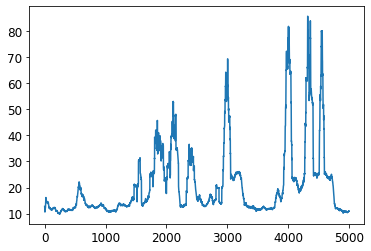

In [24]:
plt.plot(mean_rewards)